In [1]:
import pandas as pd 
import numpy as np
import re
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 1. Missing data

In [3]:
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

Không có dữ liệu khuyết

### 2. Special Character

In [4]:
for column in df.select_dtypes(exclude='number').columns:
    special_chars = set()
    for value in df[column].unique():
        special_chars.update(re.findall(r'[^a-zA-Z0-9]', value))
    print(f"{column}: {list(special_chars)}")

Attrition: []
BusinessTravel: ['_', '-']
Department: ['&', ' ']
EducationField: [' ']
Gender: []
JobRole: [' ']
MaritalStatus: []
Over18: []
OverTime: []


In [5]:
df['Department'].unique()

array(['Sales', 'Research & Development', 'Human Resources'], dtype=object)

### 3. Feature value range

In [6]:
for column in df.select_dtypes(include='number').columns:
    print(f"{column}: [{df[column].min()}, {df[column].max()}]")
    # print('-'*50)

Age: [18, 60]
DailyRate: [102, 1499]
DistanceFromHome: [1, 29]
Education: [1, 5]
EmployeeCount: [1, 1]
EmployeeNumber: [1, 2068]
EnvironmentSatisfaction: [1, 4]
HourlyRate: [30, 100]
JobInvolvement: [1, 4]
JobLevel: [1, 5]
JobSatisfaction: [1, 4]
MonthlyIncome: [1009, 19999]
MonthlyRate: [2094, 26999]
NumCompaniesWorked: [0, 9]
PercentSalaryHike: [11, 25]
PerformanceRating: [3, 4]
RelationshipSatisfaction: [1, 4]
StandardHours: [80, 80]
StockOptionLevel: [0, 3]
TotalWorkingYears: [0, 40]
TrainingTimesLastYear: [0, 6]
WorkLifeBalance: [1, 4]
YearsAtCompany: [0, 40]
YearsInCurrentRole: [0, 18]
YearsSinceLastPromotion: [0, 15]
YearsWithCurrManager: [0, 17]


### 4. Outlier removal

Trước hết, ta xem lại phân phối dữ liệu

In [7]:
distr_col = ['Age', 'DailyRate', 'DistanceFromHome','HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 
       'TotalWorkingYears', 'TrainingTimesLastYear','YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager']

len(distr_col)

14

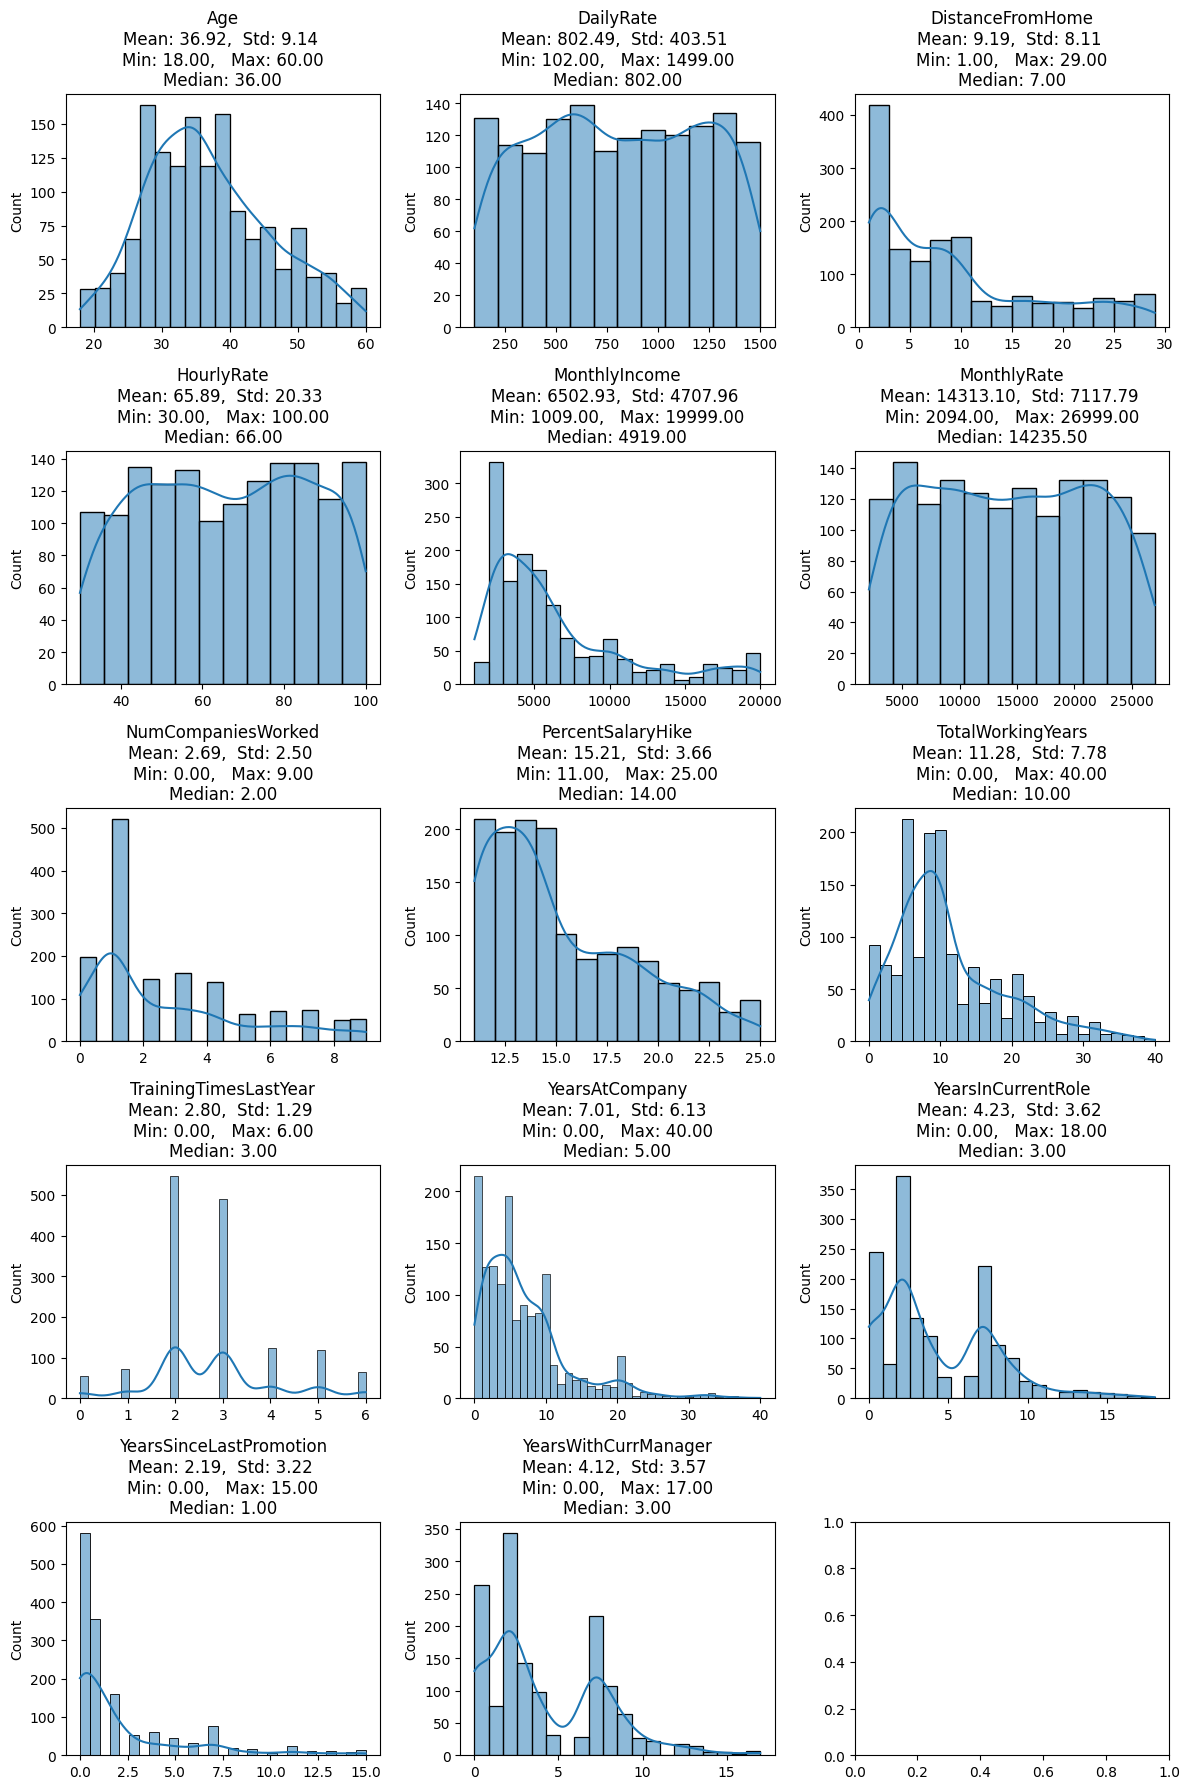

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 18)) 

for i, ax in enumerate(axes.flat):  
    if i < 14:
        sns.histplot(data=df[distr_col[i]],
                    kde=True, ax=ax)
        ax.set_title(f'{distr_col[i]}\n'
                    f'Mean: {df[distr_col[i]].mean():.2f},  Std: {df[distr_col[i]].std():.2f} \n'
                    f'Min: {df[distr_col[i]].min():.2f},   Max: {df[distr_col[i]].max():.2f}\n' 
                    f'Median: {df[distr_col[i]].median():.2f}')
        ax.set_xlabel('')
    
plt.tight_layout() 
plt.show()


Q-Q plot

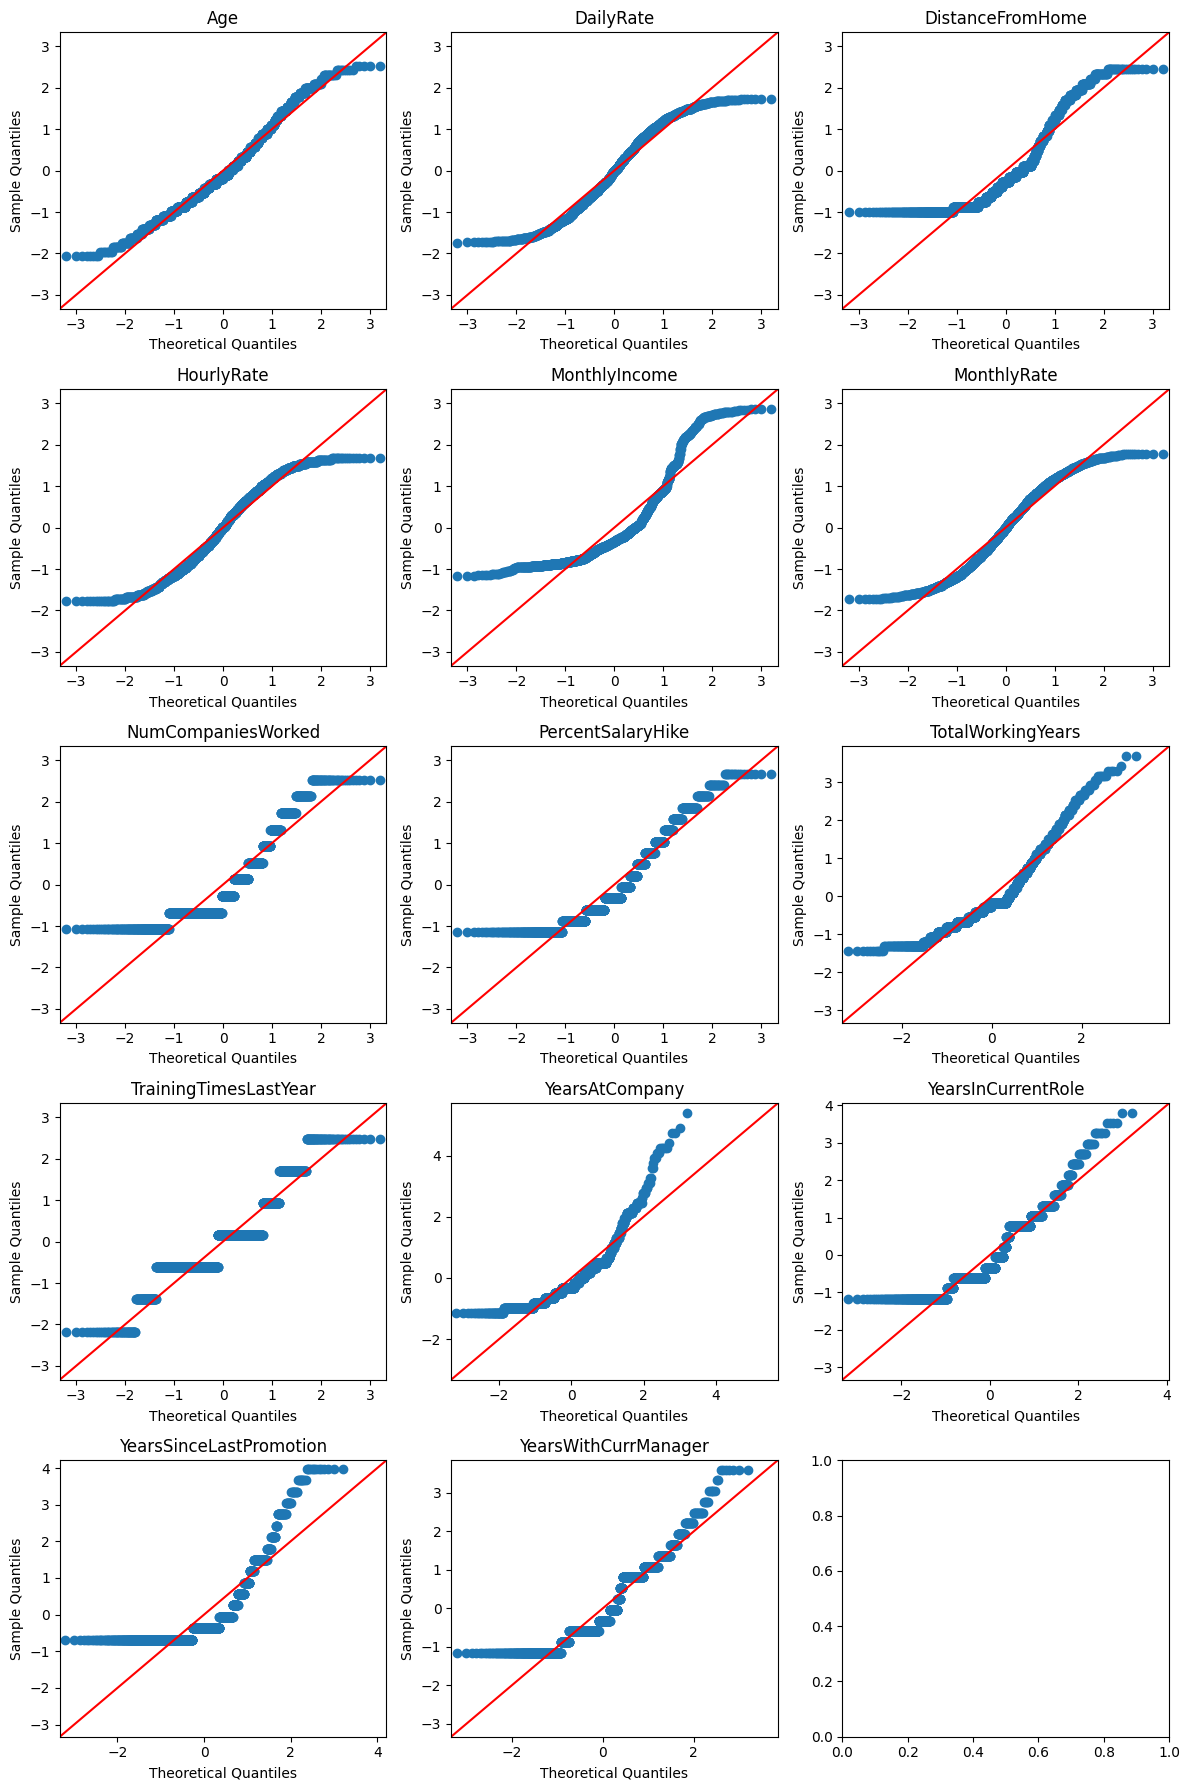

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 18))

for i, ax in enumerate(axes.flat):  
    if i < len(distr_col):  
        sm.qqplot(df[distr_col[i]], line='45', fit=True, dist=stats.norm, ax=ax)
        ax.set_title(distr_col[i]) 

plt.tight_layout()  
plt.show()


* Chỉ có biến số tuổi gần với phân phối chuẩn --> Z-score

* HourlyRate, DailyRate và MonthlyRate gần với phân phối đều --> IQR

* Một số biến lệch phải như DistanceFromHome, MonthlyIncome, PercentSalaryHike, YearsAtCompany, TotalWorkingYear, YearsSinceLastPromotion --> IQR

* Các biến còn lại --> Percentile

Treating Outliers:

https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/#h-for-normal-distributions

In [10]:
new_df = df.copy()

In [11]:
lower = df['Age'].mean() - 3 * df['Age'].std()
upper = df['Age'].mean() + 3 * df['Age'].std()

df[(df['Age'] < lower) | (df['Age'] > upper)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [12]:
cols = ['HourlyRate', 'DailyRate', 'MonthlyRate']

for column in cols:
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

HourlyRate, outlier 0 rows
DailyRate, outlier 0 rows
MonthlyRate, outlier 0 rows


In [13]:
cols = ['DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'TotalWorkingYears', 'YearsSinceLastPromotion']

for column in cols:
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

DistanceFromHome, outlier 0 rows
MonthlyIncome, outlier 114 rows
PercentSalaryHike, outlier 0 rows
YearsAtCompany, outlier 104 rows
TotalWorkingYears, outlier 63 rows
YearsSinceLastPromotion, outlier 107 rows


In [14]:
cols = ['NumCompaniesWorked', 'TrainingTimesLastYear','YearsInCurrentRole', 'YearsWithCurrManager']

for column in cols:
    upper_limit = df[column].quantile(0.99)
    lower_limit = df[column].quantile(0.01)
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

NumCompaniesWorked, outlier 0 rows
TrainingTimesLastYear, outlier 0 rows
YearsInCurrentRole, outlier 13 rows
YearsWithCurrManager, outlier 14 rows


Thử plot dữ liệu trước và sau khi loại bỏ outlier

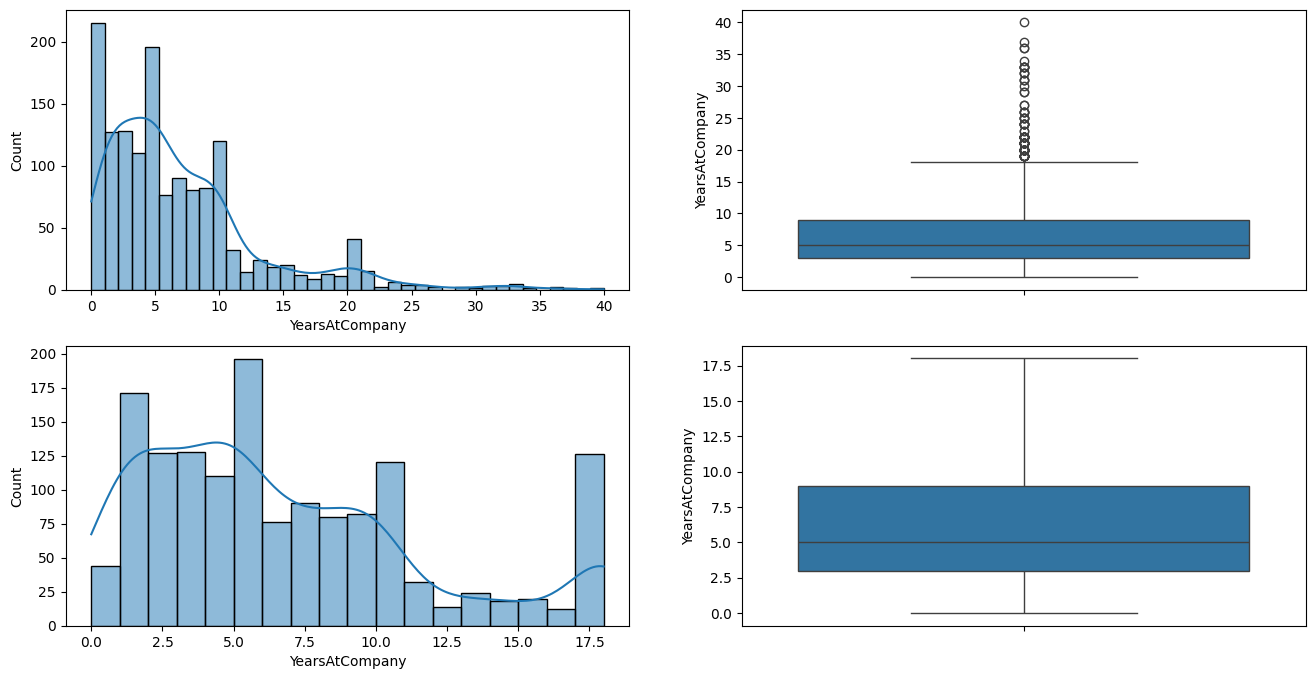

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df['YearsAtCompany'], kde=True)
plt.subplot(2,2,2)
sns.boxplot(df['YearsAtCompany'])
plt.subplot(2,2,3)
sns.histplot(new_df['YearsAtCompany'], kde=True)
plt.subplot(2,2,4)
sns.boxplot(new_df['YearsAtCompany'])
plt.show()

* Vấn đề đối với các outlier: ở đây các dữ liệu đều là dữ liệu thực tế, tức là outlier có đại diện cho dữ liệu thực tế (ví dụ: số năm làm việc trong công ty trên 30 năm) chứ không phải phát sinh do lỗi dữ liệu. 
* Việc loại bỏ outlier có thể gây mất dữ liệu thực tế, mất mát hoặc làm sai lệch các thông tin quan trọng. Chẳng hạn như trên biểu đồ, một số lượng lớn nhân viên có chưa đầy 1 năm làm việc tại công ty được thay thế bằng số năm lớn hơn, điều này không phù hợp.

$\rightarrow$ Việc loại bỏ outlier sẽ được quyết định trong quá trình huấn luyện mô hình

### 5. Feature Engineering

#### 5.1. Label encoding

In [16]:
df_encoded = df.copy()
df_encoded.select_dtypes(exclude='number').columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [18]:
le = LabelEncoder()
for col in df_encoded.columns:
    le.fit(df_encoded[col])
    df_encoded[col] = le.transform(df_encoded[col])

In [19]:
df_encoded.select_dtypes(exclude='number').columns

Index([], dtype='object')

#### 5.2. Feature Scaling

Ở đây ta chỉ scale các biến có khoảng giá trị liên tục, loại trừ các biến categorical đã được encode và các biến chỉ có các giá trị phân loại (1,2,3,4)

* Chỉ có biến số tuổi gần với phân phối chuẩn --> Standard Scaling

* HourlyRate, DailyRate và MonthlyRate gần với phân phối đều --> MinMax Scaling

* Một số biến lệch phải như DistanceFromHome, MonthlyIncome, PercentSalaryHike, YearsAtCompany, TotalWorkingYear, YearsSinceLastPromotion --> log transformation

* Các biến còn lại --> Standard Scaling

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
scaled_df = df_encoded.copy()

In [22]:
stdscl = StandardScaler()
scaled_df['Age'] = stdscl.fit_transform(scaled_df[['Age']])

In [23]:
for column in ['HourlyRate', 'DailyRate', 'MonthlyRate']:
    mmscl = MinMaxScaler()
    scaled_df[column] = mmscl.fit_transform(scaled_df[[column]])

In [24]:
for column in ['DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 
               'YearsAtCompany', 'TotalWorkingYears', 'YearsSinceLastPromotion']:
    scaled_df[column] = np.log1p(scaled_df[column])

In [25]:
for column in ['NumCompaniesWorked', 'TrainingTimesLastYear','YearsInCurrentRole', 'YearsWithCurrManager']:
    stdscl = StandardScaler()
    scaled_df[column] = stdscl.fit_transform(scaled_df[[column]])

In [26]:
for column in scaled_df.select_dtypes(include='number').columns:
    print(f"{column}: [{scaled_df[column].min()}, {scaled_df[column].max()}]")

Age: [-2.072192177156677, 2.526885578888087]
Attrition: [0, 1]
BusinessTravel: [0, 2]
DailyRate: [0.0, 1.0]
Department: [0, 2]
DistanceFromHome: [0.0, 3.367295829986474]
Education: [0, 4]
EducationField: [0, 5]
EmployeeCount: [0, 0]
EmployeeNumber: [0, 1469]
EnvironmentSatisfaction: [0, 3]
Gender: [0, 1]
HourlyRate: [0.0, 1.0]
JobInvolvement: [0, 3]
JobLevel: [0, 4]
JobRole: [0, 8]
JobSatisfaction: [0, 3]
MaritalStatus: [0, 2]
MonthlyIncome: [0.0, 7.207118856207756]
MonthlyRate: [0.0, 1.0]
NumCompaniesWorked: [-1.0785044383346125, 2.5255909693862573]
Over18: [0, 0]
OverTime: [0, 1]
PercentSalaryHike: [0.0, 2.70805020110221]
PerformanceRating: [0, 1]
RelationshipSatisfaction: [0, 3]
StandardHours: [0, 0]
StockOptionLevel: [0, 3]
TotalWorkingYears: [0.0, 3.6888794541139363]
TrainingTimesLastYear: [-2.171981830933257, 2.4833959938131165]
WorkLifeBalance: [0, 3]
YearsAtCompany: [0.0, 3.6109179126442243]
YearsInCurrentRole: [-1.1676872598353414, 3.8020738621275236]
YearsSinceLastPromotion: 

#### 5.2. Feature selection

Theo như phân tích EDA ban đầu, có 4 cột sẽ được loại bỏ vì không có ý nghĩa và ảnh hưởng đến biến mục tiêu:
* **Over18**, **EmployeeCount, StandardHours** chỉ chứa duy nhất 1 giá trị
* **EmployeeNumber** là mã số định danh của nhân viên trong công ty

In [27]:
new_df = scaled_df.drop(columns=['Over18','EmployeeCount','StandardHours','EmployeeNumber'])
new_df.columns.shape

(31,)

##### 5.2.1. Recursive Feature Elimination (RFE)

Thay vì PCA, thuật toán RFE sẽ được sử dụng để giữ lại ý nghĩa của dữ liệu, vì PCA biến đổi dữ liệu sang chiều không gian mới

In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [29]:
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=20)

features = new_df.drop(['Attrition'], axis=1)
target = new_df['Attrition']

rfe.fit(features, target)
selected_features = features.columns[rfe.support_]
feature_ranking = rfe.ranking_  

print("Selected Features and corresponding rank:")
for feature, rank in zip(features.columns, feature_ranking):
    print(f"Feature: {feature}, Rank: {rank}")


Selected Features and corresponding rank:
Feature: Age, Rank: 3
Feature: BusinessTravel, Rank: 11
Feature: DailyRate, Rank: 1
Feature: Department, Rank: 1
Feature: DistanceFromHome, Rank: 1
Feature: Education, Rank: 9
Feature: EducationField, Rank: 7
Feature: EnvironmentSatisfaction, Rank: 1
Feature: Gender, Rank: 1
Feature: HourlyRate, Rank: 4
Feature: JobInvolvement, Rank: 1
Feature: JobLevel, Rank: 10
Feature: JobRole, Rank: 5
Feature: JobSatisfaction, Rank: 1
Feature: MaritalStatus, Rank: 1
Feature: MonthlyIncome, Rank: 1
Feature: MonthlyRate, Rank: 6
Feature: NumCompaniesWorked, Rank: 1
Feature: OverTime, Rank: 1
Feature: PercentSalaryHike, Rank: 1
Feature: PerformanceRating, Rank: 1
Feature: RelationshipSatisfaction, Rank: 1
Feature: StockOptionLevel, Rank: 1
Feature: TotalWorkingYears, Rank: 1
Feature: TrainingTimesLastYear, Rank: 1
Feature: WorkLifeBalance, Rank: 1
Feature: YearsAtCompany, Rank: 8
Feature: YearsInCurrentRole, Rank: 1
Feature: YearsSinceLastPromotion, Rank: 1
Fe

##### 5.2.2. Multicollinearity Elimination

In [30]:
from sklearn.feature_selection import VarianceThreshold

<Axes: >

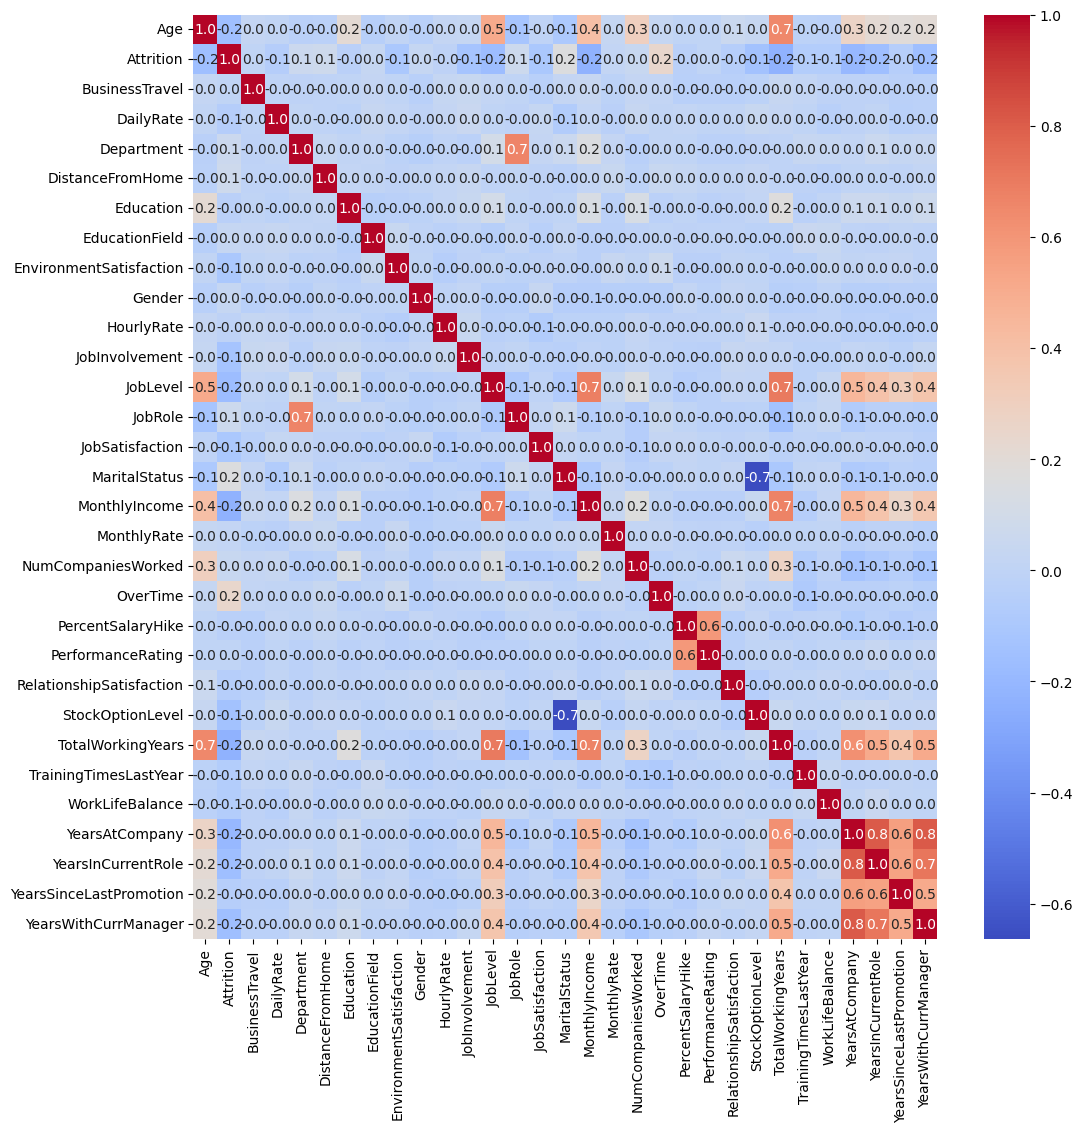

In [35]:
plt.figure(figsize=(12,12))
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm', fmt='.1f')